In [1]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import TFViTForImageClassification, ViTConfig, ViTImageProcessor, Trainer, TrainingArguments, AutoImageProcessor
from torchvision.transforms import v2
import torch.nn as nn

2026-01-14 21:32:03.133515: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-14 21:32:03.165975: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/cond

In [2]:
# Loading dataset
animal_dataset = load_dataset("imagefolder", data_dir="../../../data/animal_images")
animal_dataset

Resolving data files:   0%|          | 0/30000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2407 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2407
    })
})

In [3]:
# Checking example structure of dataset in training data
features = animal_dataset["train"].features
features

{'image': Image(mode=None, decode=True),
 'label': ClassLabel(names=['Beetle', 'Butterfly', 'Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Lizard', 'Monkey', 'Mouse', 'Panda', 'Spider', 'Tiger', 'Zebra'])}

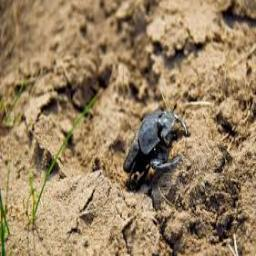

In [4]:
# Visualization of example content of dataset
animal_dataset['train'][10]['image']

In [5]:
# Splitting into seperate datasets to parse onto trainer later on
train_data = animal_dataset["train"]
validation_data = animal_dataset["validation"]
test_data = animal_dataset["test"]

In [6]:
# Label mapping for model (label-name -> index)
id2label = {id: label for id, label in enumerate(train_data.features["label"].names)}
label2id = {label: id for id, label in id2label.items()}
id2label, id2label[train_data[0]["label"]]

({0: 'Beetle',
  1: 'Butterfly',
  2: 'Cat',
  3: 'Cow',
  4: 'Dog',
  5: 'Elephant',
  6: 'Gorilla',
  7: 'Hippo',
  8: 'Lizard',
  9: 'Monkey',
  10: 'Mouse',
  11: 'Panda',
  12: 'Spider',
  13: 'Tiger',
  14: 'Zebra'},
 'Beetle')

In [7]:
# Loading processor
processor = AutoImageProcessor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k', do_rescale = False, return_tensors = 'pt')
processor

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


BeitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": false,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [8]:
from torchvision import transforms 

# Get configurations from ViT processor
size = processor.size.get("height", 224)
image_mean, image_std = processor.image_mean, processor.image_std

# Normalization and augmentation transformations
transformations = {
    "train": transforms.Compose([
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.RandomResizedCrop(size),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=image_mean, std=image_std),
    ]),
    "validation": transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=image_mean, std=image_std),
    ]),
    "test": transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=image_mean, std=image_std),
    ]),
}


In [9]:
# Function to find the specified transformation configuration and apply it to the given example for 
def transform(examples, kind="train"):
    transform_fn = transformations.get(kind, transformations["train"])
    examples["pixel_values"] = [transform_fn(img.convert("RGB")) for img in examples["image"]]
    return examples
    
# Attaching right transformations to each dataset
train_data.set_transform(lambda examples: transform(examples, "train"))
validation_data.set_transform(lambda examples: transform(examples, "validation"))
test_data.set_transform(lambda examples: transform(examples, "test"))

In [10]:
import torch
from torch.utils.data import DataLoader

# Function fixes issue with data-types, as default trainer collate function is not aware how to stack the tensors from our dataset
def collate_fn(examples):
    # Stacks the pixel values of all examples into a single tensor and collects labels into a tensor
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels, "interpolate_pos_encoding": True}

In [11]:
# Model loading
import tensorflow as tf
from transformers import ViTForImageClassification, ViTConfig, SwinModel, AutoModelForImageClassification, BeitForImageClassification
import torch
import torch.nn as nn
import math
import types
import random

labels = animal_dataset['train'].features['label'].names
BASE_MODEL_CONF = "microsoft/beit-base-patch16-224-pt22k-ft22k"

PATCH_SIZE = 16

# Label mapping and patch size are defined in config
config = ViTConfig.from_pretrained(BASE_MODEL_CONF)
config.patch_size = PATCH_SIZE
config.num_labels = len(labels)
config.id2label = id2label
config.label2id = label2id

# Eager attention implementation to access attention outputs in model
config._attn_implementation = "eager"

# Loading model with proper label mapping + configurable patch size
model = BeitForImageClassification.from_pretrained(
    BASE_MODEL_CONF,
    config=config,
    ignore_mismatched_sizes=True,)

model

You are using a model of type beit to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([15]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (int

In [17]:
from transformers import TrainingArguments, Trainer
import numpy as np
from transformers import EarlyStoppingCallback

# Training params
TRAINING_STRATEGY = "beit_paper1"
BATCH_SIZE = 32
EPOCHS = 5
STEPS = 200

output_dir = f"results_final/output_beit_training_paper1_epochs_{EPOCHS}"

train_configs = {
    "beit_paper1": TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=BATCH_SIZE,
        eval_strategy="epoch",
        save_steps=1,
        eval_steps=1,
        warmup_steps=1, 
        num_train_epochs=EPOCHS,
        fp16=True,
        logging_strategy="steps",
        logging_steps=STEPS,
        weight_decay=0.05,
        lr_scheduler_type="cosine_warmup_with_min_lr",
        lr_scheduler_kwargs={"min_lr": 1e-5, },
        learning_rate=1.5e-3,
        optim="adamw_torch",
        max_grad_norm=3.0,
        remove_unused_columns=False,
        metric_for_best_model="accuracy",
        load_best_model_at_end=True,
        greater_is_better=True,
        report_to="tensorboard",
        save_strategy="epoch",
        save_total_limit=3,
        seed = 123
    ),
}

In [18]:
import numpy as np
import evaluate
from sklearn.metrics import confusion_matrix

# Load standard evaluation metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

# Function called after completing eval strategy rule
def compute_metrics(eval_pred):
    # Accessing model predictions
    preds = eval_pred.predictions
    labels = eval_pred.label_ids

    # Now receiving tuple because if output_attentions = True
    if isinstance(preds, (tuple, list)):
        preds = preds[0]
    # Takes the model output with the highest value (so the most likely class to be predicted)
    pred_ids = np.argmax(preds, axis=-1)

    # Computing cross entropy loss (mean) on evaluation outputs
    # CE = -log softmax(logits)
    lse = np.logaddexp.reduce(preds, axis=-1)
    true_logits = preds[np.arange(preds.shape[0]), labels]
    ce = np.mean(lse - true_logits)

    # Computing Shannon entropy (mean) on evaluation outputs
    # H(p) = -sum p log p
    log_probs = preds - lse[:, None]
    probs = np.exp(log_probs)
    entropy = np.mean(-np.sum(probs * log_probs, axis=-1))

    # Computing all predefined metrics
    return {
        "accuracy": accuracy.compute(predictions=pred_ids, references=labels)["accuracy"],
        "precision": precision.compute(predictions=pred_ids, references=labels, average="weighted")["precision"],
        "recall": recall.compute(predictions=pred_ids, references=labels, average="weighted")["recall"],
        "f1": f1.compute(predictions=pred_ids, references=labels, average="weighted")["f1"],
        "cross_entropy(val_acc)": float(ce),
        "entropy": float(entropy),
    }


In [19]:
# Make the model always return attentions
# model.config.output_attentions = True
# model.config.return_dict = True

# Initializes trainer with custom entropy loss regularization
trainer = Trainer(
    model=model,
    args=train_configs.get(TRAINING_STRATEGY),
    train_dataset=train_data,
    eval_dataset=validation_data,
    data_collator=collate_fn,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)],
)

trainer.train()


/tmp/ipykernel_781346/2077467880.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cross Entropy(val Acc),Entropy
1,2.424600,2.492508,0.185000,0.228857,0.185000,0.166350,2.492507,2.434624
2,2.266900,2.355273,0.230500,0.253061,0.230500,0.214426,2.355264,2.273821
3,2.156500,nan,0.280500,0.301905,0.280500,0.253367,nan,nan
4,2.047600,nan,0.100000,0.010000,0.100000,0.018182,nan,nan
5,0.000000,nan,0.100000,0.010000,0.100000,0.018182,nan,nan


/tmp/ipykernel_781346/3807694291.py:25: RuntimeWarning: invalid value encountered in reduce
  lse = np.logaddexp.reduce(preds, axis=-1)
/tmp/ipykernel_781346/3807694291.py:25: RuntimeWarning: invalid value encountered in reduce
  lse = np.logaddexp.reduce(preds, axis=-1)
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/tmp/ipykernel_781346/3807694291.py:25: RuntimeWarning: invalid value encountered in reduce
  lse = np.logaddexp.reduce(preds, axis=-1)
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

TrainOutput(global_step=4690, training_loss=1.7531668917202492, metrics={'train_runtime': 1270.0145, 'train_samples_per_second': 118.109, 'train_steps_per_second': 3.693, 'total_flos': 1.16201846412288e+19, 'train_loss': 1.7531668917202492, 'epoch': 5.0})

/tmp/ipykernel_781346/3807694291.py:25: RuntimeWarning: invalid value encountered in reduce
  lse = np.logaddexp.reduce(preds, axis=-1)


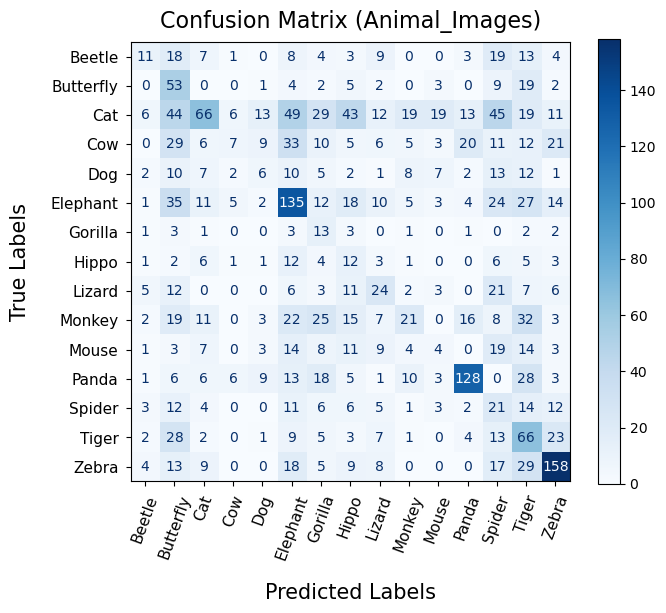



 scikit-learn report: 
              precision    recall  f1-score      support
Beetle         0.275000  0.110000  0.157143   100.000000
Butterfly      0.184669  0.530000  0.273902   100.000000
Cat            0.461538  0.167513  0.245810   394.000000
Cow            0.250000  0.039548  0.068293   177.000000
Dog            0.125000  0.068182  0.088235    88.000000
Elephant       0.389049  0.441176  0.413476   306.000000
Gorilla        0.087248  0.433333  0.145251    30.000000
Hippo          0.079470  0.210526  0.115385    57.000000
Lizard         0.230769  0.240000  0.235294   100.000000
Monkey         0.269231  0.114130  0.160305   184.000000
Mouse          0.083333  0.040000  0.054054   100.000000
Panda          0.663212  0.540084  0.595349   237.000000
Spider         0.092920  0.210000  0.128834   100.000000
Tiger          0.220736  0.402439  0.285097   164.000000
Zebra          0.593985  0.585185  0.589552   270.000000
accuracy       0.301205  0.301205  0.301205     0.301205
macro 

In [20]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Evaluation of model
predictions = trainer.predict(test_data)

# Ids of True Labels
labels_true = predictions.label_ids
# Ids of predicted labels
labels_pred = np.argmax(predictions.predictions, axis=-1)

# Configs for label <-> id mapping
id2label = model.config.id2label
label2id = model.config.label2id

# Plot of confusion matrix
result_confusion = confusion_matrix(labels_true, labels_pred)

fig, ax = plt.subplots(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=result_confusion, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=70, values_format="d", ax=ax)

ax.set_xlabel("Predicted Labels", fontsize=15, labelpad=15)
ax.set_ylabel("True Labels", fontsize=15, labelpad=15)
ax.set_title("Confusion Matrix (Animal_Images)", fontsize=16, pad=10)

ax.tick_params(axis="x", labelsize=11, pad=5)
ax.tick_params(axis="y", labelsize=11, pad=5)
plt.tight_layout()

output_path = f"{output_dir}/confusion_matrix.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

plt.show()


# Output of sklearn classification report
report = classification_report(
    labels_true,
    labels_pred,
    target_names=labels,
    output_dict=True,
)

report_df = pd.DataFrame(report).transpose()

print(f"\n\n scikit-learn report: \n{report_df}")

report_df.to_csv(f"{output_dir}/classification_report.csv", index=True)